In [2]:
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import datetime
import warnings
warnings.filterwarnings("ignore")
from IPython.display import Image
import mlflow



In [3]:
version = "v1.0"
data_url = "../data/flights.csv"

In [4]:
import sys  
#sys.path.insert(0, 'C:/Users/debgn/MLOPS/backend/src/')
sys.path.insert(0, '../backend/src/')
import data_preprocessing_training
from data_preprocessing_training import preprocess_and_split

In [5]:
from dotenv import load_dotenv
import os
load_dotenv("../backend/src/secret.env")

DagsHub_username = os.getenv("DAGHUB_USERNAME")
DagsHub_token=os.getenv("DAGHUB_PASSWORD")

In [6]:
import os
os.environ['MLFLOW_TRACKING_USERNAME']= DagsHub_username
os.environ['MLFLOW_TRACKING_PASSWORD'] = DagsHub_token

In [7]:
#setup mlflow
mlflow.set_tracking_uri('https://dagshub.com/deb.gnuito/MLOPS.mlflow') #your mlfow tracking uri
mlflow.set_experiment("flight-delay-experiment")

<Experiment: artifact_location='mlflow-artifacts:/485747da72104056a246976d414a7ec0', creation_time=1734056596207, experiment_id='0', last_update_time=1734056596207, lifecycle_stage='active', name='flight-delay-experiment', tags={}>

In [9]:
#read the data
df = pd.read_csv(data_url)

In [10]:
#shape of the data
df.shape

(5819079, 31)

In [11]:
#cleaning and preprocessing
X_train,X_test,y_train,y_test = preprocess_and_split(df)

Aucun changement d√©tect√© pour airport_encoder.pickle.


In [12]:
X_train.head()

MONTH  ORIGIN_AIRPORT  DESTINATION_AIRPORT  DEPARTURE_DELAY  \
5272295     11             497                  450             -6.0   
5678727     12             523                  391              8.0   
2102837      5             576                  393             -1.0   
5765214     12             502                  489             -2.0   
950249       3             346                  373            -10.0   

         SCHEDULED_TIME  AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  \
5272295            80.0               0.0             0.0            0.0   
5678727           144.0               9.0             0.0            0.0   
2102837            74.0               0.0             0.0            0.0   
5765214           125.0               0.0             0.0            0.0   
950249            143.0               0.0             0.0            0.0   

         LATE_AIRCRAFT_DELAY  WEATHER_DELAY  ...  AIRLINE_EV  AIRLINE_F9  \
5272295                  0.0            0.0  ...         0.0         0.0   
5678727                  8.0            0.0  ...         0.0         0.0   
2102837                  0.0            0.0  ...         0.0         0.0   
5765214                  0.0            0.0  ...         0.0         0.0   
950249                   0.0            0.0  ...         0.0         0.0   

         AIRLINE_HA  AIRLINE_MQ  AIRLINE_NK  AIRLINE_OO  AIRLINE_UA  \
5272295         0.0         0.0         0.0         0.0         0.0   
5678727         0.0         0.0         0.0         0.0         0.0   
2102837         0.0         0.0         0.0         0.0         0.0   
5765214         0.0         0.0         0.0         0.0         0.0   
950249          0.0         0.0         0.0         0.0         0.0   

         AIRLINE_US  AIRLINE_VX  AIRLINE_WN  
5272295         0.0         0.0         1.0  
5678727         0.0         0.0         0.0  
2102837         0.0         0.0         0.0  
5765214         0.0         0.0         1.0  
950249          0.0         0.0         0.0  

[5 rows x 28 columns]

In [13]:
X_train.columns


Index(['MONTH', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY',
       'SCHEDULED_TIME', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'DEPARTURE_TIME_HOUR',
       'DEPARTURE_TIME_MINUTE', 'SCHEDULED_ARRIVAL_HOUR',
       'SCHEDULED_ARRIVAL_MINUTE', 'AIRLINE_AA', 'AIRLINE_AS', 'AIRLINE_B6',
       'AIRLINE_DL', 'AIRLINE_EV', 'AIRLINE_F9', 'AIRLINE_HA', 'AIRLINE_MQ',
       'AIRLINE_NK', 'AIRLINE_OO', 'AIRLINE_UA', 'AIRLINE_US', 'AIRLINE_VX',
       'AIRLINE_WN'],
      dtype='object')

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4655263 entries, 5272295 to 1692743
Data columns (total 28 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   MONTH                     int64  
 1   ORIGIN_AIRPORT            int32  
 2   DESTINATION_AIRPORT       int32  
 3   DEPARTURE_DELAY           float64
 4   SCHEDULED_TIME            float64
 5   AIR_SYSTEM_DELAY          float64
 6   SECURITY_DELAY            float64
 7   AIRLINE_DELAY             float64
 8   LATE_AIRCRAFT_DELAY       float64
 9   WEATHER_DELAY             float64
 10  DEPARTURE_TIME_HOUR       int64  
 11  DEPARTURE_TIME_MINUTE     int64  
 12  SCHEDULED_ARRIVAL_HOUR    int64  
 13  SCHEDULED_ARRIVAL_MINUTE  int64  
 14  AIRLINE_AA                float64
 15  AIRLINE_AS                float64
 16  AIRLINE_B6                float64
 17  AIRLINE_DL                float64
 18  AIRLINE_EV                float64
 19  AIRLINE_F9                float64
 20  AIRLINE_HA        

# 2. Machine Learning Modeling :


Etablison la **Baseline**

Le principe de la baseline en machine learning consiste √† d√©finir une r√©f√©rence simple ou une m√©thode triviale pour pr√©dire les r√©sultats. Cette r√©f√©rence sert √† √©valuer les performances d‚Äôun mod√®le de mani√®re relative. Si un mod√®le ne fait pas mieux que cette baseline, il est consid√©r√© comme inefficace ou inutile, car il n'apporte pas de valeur ajout√©e par rapport √† une approche simple.

In [39]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Baseline predictions: moyenne des y_train
baseline_preds = y_train.agg('sum') / y_train.agg('count')

# Baseline errors
baseline_errors = abs(baseline_preds - y_test)

# 1. MAE - Mean Absolute Error
mae = np.mean(baseline_errors)
print('Mean Absolute Error (MAE):', round(mae, 2))

# 2. MSE - Mean Squared Error
mse = mean_squared_error([baseline_preds] * len(y_test), y_test)
print('Mean Squared Error (MSE):', round(mse, 2))

# 3. RMSE - Root Mean Squared Error
rmse = np.sqrt(mse)
print('Root Mean Squared Error (RMSE):', round(rmse, 2))

# 4. R¬≤ - Coefficient of Determination
r2 = r2_score(y_test, [baseline_preds] * len(y_test))
print('R¬≤ (Coefficient of Determination):', round(r2, 2))


Mean Absolute Error (MAE): 21.03
Mean Squared Error (MSE): 1530.77
Root Mean Squared Error (RMSE): 39.13
R¬≤ (Coefficient of Determination): -0.0


Il s‚Äôagit de notre erreur de base moyenne de 21.04 minutes de retard que nous souhaitons surmonter avec notre mod√®le de r√©gression. Un model doit minimum avoir les erreur inf√©rieur √† celui de baseline sinon il sera rejett√©

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb


# D√©finition correcte des mod√®les
Linear_Regression = LinearRegression()
model_xgb = xgb.XGBRegressor(n_estimators=100, random_state=42)
Decision_Tree = DecisionTreeRegressor(random_state=42)


In [15]:
# Entra√Ænement des mod√®les
Linear_Regression.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
Decision_Tree.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [16]:
# Pr√©dictions sur les donn√©es de test
y_pred_lr = Linear_Regression.predict(X_test)
y_pred_xgb = model_xgb.predict(X_test)
y_pred_dt = Decision_Tree.predict(X_test)

### 1. Mean Squared Error (MSE) - Erreur quadratique moyenne
Le **MSE** mesure la moyenne des carr√©s des erreurs, c'est-√†-dire la diff√©rence au carr√© entre la valeur r√©elle et la valeur pr√©dite. Plus cette valeur est faible, meilleure est la performance du mod√®le. Cette valeur reste relative d'un cas ou √† un autre 


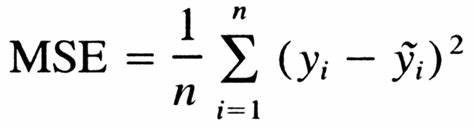

In [17]:
Image(filename="images/mse.jpg", width=500, height=100)

--------------------------------------------------------------------------------------------------------------------------

### 2. Root Mean Squared Error (RMSE) - Erreur quadratique moyenne racine
Le **RMSE** est simplement la racine carr√©e du MSE. Il est utilis√© pour ramener l'√©chelle des erreurs √† l'√©chelle originale des donn√©es, ce qui le rend plus facile √† interpr√©ter.

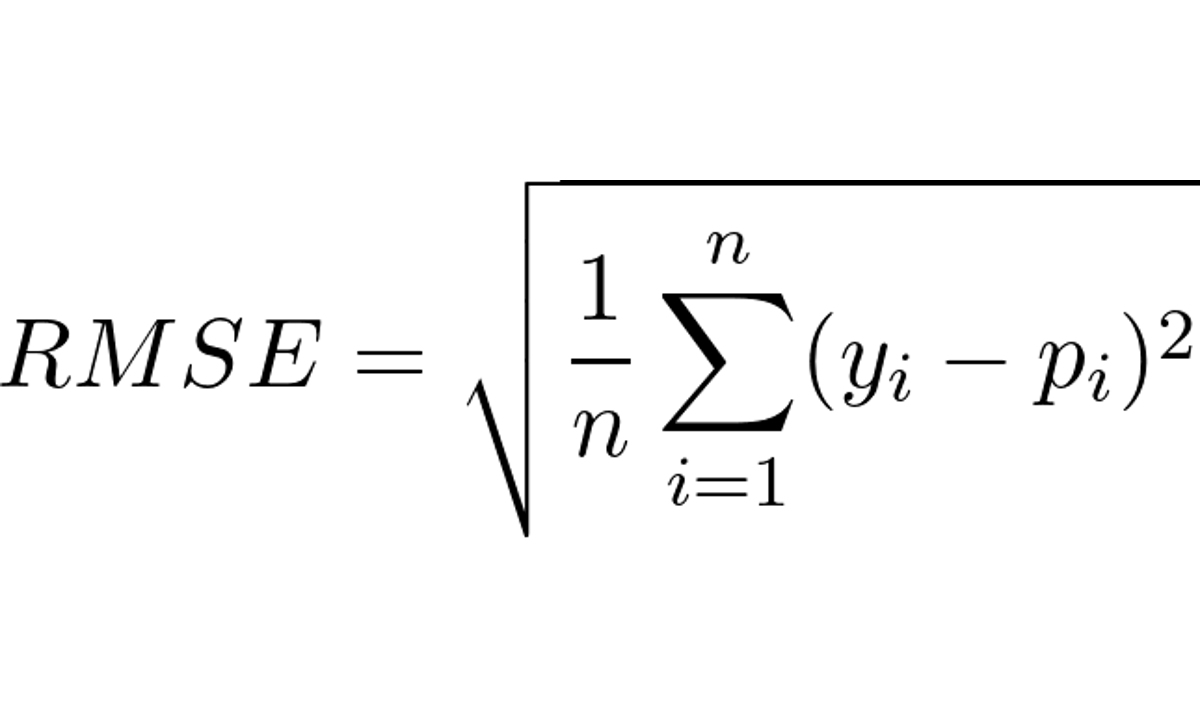

In [18]:
Image(filename="images/rmse.png", width=400, height=200)

--------------------------------------------------------------------------------------------------------------------------

### 3. Mean Absolute Error (MAE) - Erreur absolue moyenne
Le **MAE** mesure la moyenne des erreurs absolues, c'est-√†-dire la diff√©rence absolue entre la valeur r√©elle et la valeur pr√©dite.

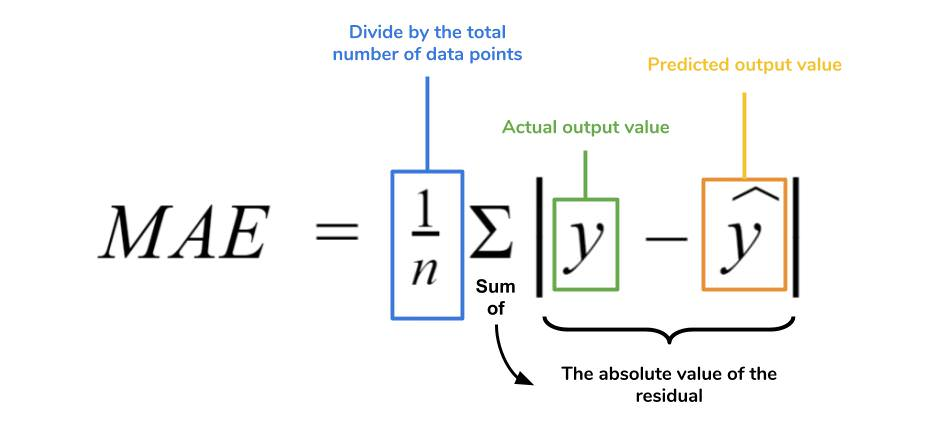

In [19]:
Image(filename="images/mae.jpg", width=500, height=200)

--------------------------------------------------------------------------------------------------------------------------

### R¬≤ Score (Coefficient de d√©termination)
Le R¬≤ score, √©galement appel√© coefficient de d√©termination, indique la proportion de la variance dans la variable cible qui est expliqu√©e par le mod√®le. Il est calcul√© comme suit :

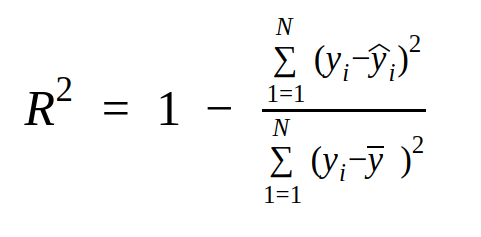

In [20]:
Image(filename="images/r2.png", width=500, height=200)

* Il montre dans quelle mesure le mod√®le capture la variance des donn√©es.
* Un R¬≤ proche de 1 indique que le mod√®le explique une grande partie de la variance des donn√©es, tandis qu'un R¬≤ proche de 0 indique que le mod√®le est inefficace.
* Le R¬≤ est tr√®s utile pour comparer des mod√®les de r√©gression diff√©rents.

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Fonction pour calculer les m√©triques
def evaluate_model(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R¬≤": r2}

print("******************************Evaluation Linear Regression********************")
score_lr= evaluate_model(y_test,y_pred_lr)
for metric, value in score_lr.items():
    print(f"{metric}: {value:.4f}")

print("******************************Evaluation model_xgb********************")
score_xgb= evaluate_model(y_test,y_pred_xgb)
for metric, value in score_xgb.items():
    print(f"{metric}: {value:.4f}")

print("******************************Evaluation Decision_Tree********************")
score_dt= evaluate_model(y_test,y_pred_dt)
for metric, value in score_dt.items():
    print(f"{metric}: {value:.4f}")


******************************Evaluation Linear Regression********************
MAE: 7.2507
MSE: 87.0474
RMSE: 9.3299
R¬≤: 0.9431
******************************Evaluation model_xgb********************
MAE: 6.0193
MSE: 79.1310
RMSE: 8.8956
R¬≤: 0.9483
******************************Evaluation Decision_Tree********************
MAE: 6.9100
MSE: 105.1915
RMSE: 10.2563
R¬≤: 0.9313


### **Finetuning du LinearRegression**

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Param√®tres √† tester
param_grid = {
    'fit_intercept': [True, False],  # Ajouter une constante ou non
}

# Initialisation du mod√®le
lr = LinearRegression()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimisation par R¬≤
    cv=5,  # Validation crois√©e √† 5 plis
    verbose=2
)

# Lancer la recherche
grid_search.fit(X_train, y_train)

best_params_lr = grid_search.best_params_
print("Meilleurs hyperparam√®tres (Random Search) : ", best_params_lr)
# R√©cup√©rer le meilleur mod√®le
best_model_lr = grid_search.best_estimator_


Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .................................fit_intercept=True; total time=   9.8s
[CV] END .................................fit_intercept=True; total time=   8.3s
[CV] END .................................fit_intercept=True; total time=   8.5s
[CV] END .................................fit_intercept=True; total time=   8.6s
[CV] END .................................fit_intercept=True; total time=   8.7s
[CV] END ................................fit_intercept=False; total time=   9.0s
[CV] END ................................fit_intercept=False; total time=   9.3s
[CV] END ................................fit_intercept=False; total time=   8.8s
[CV] END ................................fit_intercept=False; total time=   9.8s
[CV] END ................................fit_intercept=False; total time=  10.7s
Meilleurs hyperparam√®tres (Random Search) :  {'fit_intercept': True}


In [24]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pred_lr1=best_model_lr.predict(X_test)
# Calcul des m√©triques
mse = mean_squared_error(y_test, pred_lr1)
mae = mean_absolute_error(y_test, pred_lr1)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_lr1)
# Afficher les m√©triques
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


MSE: 87.05
MAE: 7.25
RMSE: 9.33
R2 Score: 0.94


In [31]:
with mlflow.start_run(run_name='LinearRegression'):
    mlflow.log_param("data_url",data_url)
    mlflow.log_param("data_version",version)
    mlflow.log_param("input_rows",df.shape[0])
    mlflow.log_param("input_cols",df.shape[1])
    #model fitting and training
    lr= LinearRegression()

    mlflow.set_tag(key= "model",value="LinearRegression")
    params = lr.get_params()
    mlflow.log_params(params)
    lr.fit(X_train,y_train)
    train_features_name = f'{X_train=}'.split('=')[0]
    train_label_name = f'{y_test=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name",value= train_features_name)
    mlflow.set_tag(key= "train_label_name",value=train_label_name)

    # Pr√©dictions
    predictions = lr.predict(X_test)

    # Calcul des m√©triques
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Enregistrement des m√©triques
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE",  rmse)
    mlflow.log_metric("R2_Score", r2)

    # Enregistrer le mod√®le
    mlflow.sklearn.log_model(lr, artifact_path="ML_models")

# Afficher les m√©triques
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


2024/12/13 18:54:17 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\debgn\AppData\Local\Temp\tmpkkh3d3tt\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/12/13 18:54:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run LinearRegression at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0/runs/9e8ecf8a59e94365afcac174283db466
üß™ View experiment at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0
MSE: 87.05
MAE: 7.25
RMSE: 9.33
R2 Score: 0.94


In [37]:
lr_pred = lr.predict(X_test)

### **Finetuning du model_xgb**

In [27]:
import xgboost as xgb

# Initialiser le mod√®le XGBoost
xgb_model = xgb.XGBRegressor(random_state=42)

# D√©finir l'espace de recherche pour les hyperparam√®tres
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2]
}


from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Nombre d'it√©rations al√©atoires
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_params_xgb = random_search.best_params_
print("Meilleurs hyperparam√®tres (Random Search) : ", best_params_xgb)

# R√©cup√©rer le meilleur mod√®le
best_model_xgb = random_search.best_estimator_



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Meilleurs hyperparam√®tres (Random Search) :  {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [28]:
y_pred_xgb = best_model_xgb.predict(X_test)

print("******************************Evaluation Best model xgboost********************")
score_best= evaluate_model(y_test,y_pred_xgb)
for metric, value in score_best.items():
    print(f"{metric}: {value:.4f}")

******************************Evaluation Best model xgboost********************
MAE: 5.9459
MSE: 77.3738
RMSE: 8.7962
R¬≤: 0.9495


In [24]:
mlflow.sklearn.autolog(disable=True)

In [30]:
with mlflow.start_run(run_name='XGBRegressor'):
    mlflow.log_param("data_url",data_url)
    mlflow.log_param("data_version",version)
    mlflow.log_param("input_rows",df.shape[0])
    mlflow.log_param("input_cols",df.shape[1])
    #model fitting and training
    xgb_model = xgb.XGBRegressor(**best_params_xgb, random_state=42)

    mlflow.set_tag(key= "model",value="XGBRegressor")
    params = xgb_model.get_params()
    mlflow.log_params(params)
    xgb_model.fit(X_train,y_train)
    train_features_name = f'{X_train=}'.split('=')[0]
    train_label_name = f'{y_test=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name",value= train_features_name)
    mlflow.set_tag(key= "train_label_name",value=train_label_name)

    # Pr√©dictions
    predictions = xgb_model.predict(X_test)

    # Calcul des m√©triques
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)

    # Enregistrement des m√©triques
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE",  rmse)
    mlflow.log_metric("R2_Score", r2)

    # Enregistrer le mod√®le
    mlflow.sklearn.log_model(xgb_model, artifact_path="ML_models")

# Afficher les m√©triques
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.2f}")


2024/12/13 18:52:19 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\debgn\AppData\Local\Temp\tmpugcbbt7l\model\model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback. 
2024/12/13 18:52:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


üèÉ View run XGBRegressor at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0/runs/337c77bed65545bbb9f628bd01281728
üß™ View experiment at: https://dagshub.com/deb.gnuito/MLOPS.mlflow/#/experiments/0
MSE: 77.37
MAE: 5.95
RMSE: 8.80
R2 Score: 0.95


### **LSTM_Model**

In [32]:
with mlflow.start_run(run_name='LSTM_Model'):
    # Enregistrer les param√®tres
    mlflow.log_param("data_url", data_url)
    mlflow.log_param("data_version", version)
    mlflow.log_param("input_rows", df.shape[0])
    mlflow.log_param("input_cols", df.shape[1])

    # Cr√©er et entra√Æner le mod√®le LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))  # LSTM
    model.add(Dense(units=1))  # Couche de sortie

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Enregistrer les hyperparam√®tres
    mlflow.set_tag(key="model", value="LSTM")
    params = {"units": 50, "optimizer": "adam", "loss": "mean_squared_error"}
    mlflow.log_params(params)

    # Entra√Æner le mod√®le
    model.fit(X_train, y_train, epochs=4, batch_size=128, verbose=1)

    # Enregistrer les noms des caract√©ristiques d'entr√©e et de sortie
    train_features_name = f'{X_train=}'.split('=')[0]
    train_label_name = f'{y_train=}'.split('=')[0]
    mlflow.set_tag(key="train_features_name", value=train_features_name)
    mlflow.set_tag(key="train_label_name", value=train_label_name)
